<a href="https://colab.research.google.com/github/moji-moji-idn/Abnormal_Prediction/blob/main/CNN_LSTM_%2B_%EC%9D%B4%EC%83%81%EC%B9%98_%EC%A6%9D%EA%B0%95_%2B_Attention_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/smallcowbaby/OmniAnomaly && cd OmniAnomaly

fatal: destination path 'OmniAnomaly' already exists and is not an empty directory.


In [2]:

import numpy as np
import pandas as pd
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
std = StandardScaler()
from datetime import date
import holidays
KR_holidays = holidays.KR()
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, BatchNormalization, GRU
from keras import optimizers
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
from datetime import datetime
import datetime as dt
from tqdm import tqdm
from time import sleep
from scipy import stats


In [3]:
root_path = '/content/OmniAnomaly/ServerMachineDataset'

In [4]:
df = pd.read_csv(root_path+'/train/machine-1-6.txt')
with open(root_path+'/interpretation_label/machine-1-6.txt', 'r') as file:
    anomaly_events = file.readlines()

In [5]:
# Renaming the columns for clarity
column_names = [
    'CPU utilization rate', 'CPU utilization rate 2', 'Memory usage rate', 'Memory usage rate 2',
    'Disk read throughput', 'Disk write throughput', 'Network receive throughput', 'Network send throughput',
    'CPU user time', 'CPU system time', 'CPU idle time', 'CPU I/O wait time', 'CPU IRQ time',
    'CPU soft IRQ time', 'CPU steal time', 'Context switches', 'Interrupts', 'Load 1 minute',
    'Load 5 minutes', 'Load 15 minutes', 'Disk used space', 'Disk free space', 'Disk total space',
    'Disk read latency', 'Disk write latency', 'Disk read IOPS', 'Disk write IOPS', 'Network inbound packets',
    'Network outbound packets', 'Network inbound errors', 'Network outbound errors', 'Network inbound drops',
    'Network outbound drops', 'Network connections established', 'Network connections listening',
    'Network connections time wait', 'Network connections close wait', 'Network connections closed'
]
df.columns = column_names

# Re-display the first few rows with updated column names
df.head()

,CPU utilization rate,CPU utilization rate 2,Memory usage rate,Memory usage rate 2,Disk read throughput,Disk write throughput,Network receive throughput,Network send throughput,CPU user time,CPU system time,...,Network outbound packets,Network inbound errors,Network outbound errors,Network inbound drops,Network outbound drops,Network connections established,Network connections listening,Network connections time wait,Network connections close wait,Network connections closed
0,0.148148,0.043671,0.025748,0.023148,0.619565,0.941529,0.103722,0.0,0.081512,0.137459,...,0.0,0.179232,0.140706,0.165948,0.0,0.080851,0.121441,0.121098,0.0,0.0
1,0.419753,0.406905,0.154070,0.070833,0.619565,0.985727,0.102901,0.0,0.667574,0.207061,...,0.0,0.210526,0.133330,0.163793,0.0,0.029787,0.108405,0.108748,0.0,0.0
2,0.407407,0.303334,0.199336,0.094907,0.619565,0.947514,0.064313,0.0,0.814637,0.195025,...,0.0,0.214794,0.109206,0.105603,0.0,0.038298,0.110806,0.111149,0.0,0.0
3,0.283951,0.231632,0.209718,0.106019,0.619565,0.958103,0.062945,0.0,0.483795,0.310610,...,0.0,0.213371,0.119246,0.088362,0.0,0.042553,0.101544,0.101201,0.0,0.0
4,0.320988,0.309826,0.269103,0.137037,0.619565,0.996777,0.063218,0.0,0.538258,0.265546,...,0.0,0.243243,0.167940,0.150862,0.0,0.059574,0.145798,0.145798,0.0,0.0


In [6]:
# 2. 이상 구간 정보
anomaly_info = """
246-252:1,2,3,4,6,9,10,11,12,13,15
653-658:1,2,3,4,6,9,10,11,12,13,15,19,20,21,22,26,28,30,31,32
2092-2100:1,2,3,4,6,9,10,11,12,13,15,19,20,21,22,26,28,30,31,32
2884-2888:6
3534-3539:1,2,3,4,6,9,10,11,12,13,15,19,20,21,22
4647-5045:5,6,9,10,11,13,17,33,34
5167-5172:9,10,11,13,18
5708-5713:9,10,11,13
5873-5885:2,3,6,9,10,11,13,19,20,21,22,28,31,32
6022-6027:33,34
6412-6419:1,2,3,6,9,10,11,13,15,19,20,21,22,28,30,31,32,35,36
7851-7856:1,2,9,10,11,13,19,20,21,22,23,28,30,31,32
9291-9298:1,2,3,9,10,11,13,19,20,21,22,23,28,30,31,32
10731-10736:1,2,3,9,10,11,13,19,20,21,22,23,28,30,31,32
11467-11471:1,2,3,6,9,10,11,13,19,20,21,22,23,28,30,31,32
12171-12176:1,2,3,6,9,10,11,13,19,20,21,22,23,28,30,31,32
13069-13073:33,34
13277-13280:17
13613-13619:1,2,9,10,11,12,13,30
14603-14607:9,10,11,13,19,20,21,22,32,37
15052-15055:9,10,11,13
15397-15401:9,12,13
15802-15805:9,10,11,13
16491-16499:1,2,3,9,10,11,13,15
16718-16721:9,10,11,13
16972-16976:9,12,13,15
17931-17939:1,2,3,6,9,10,11,12,13,15,19,20,21,22,23,28,30,31,32
18600-21761:1,2,3,4,6,9,10,11,12,13,14,15,16,23,25,28,30,31,32,35,36
22252-22260:9,13,15
22417-22420:11,13

"""

# 3. 라벨 초기화
labels = np.zeros(df.shape[0], dtype=int)

# 4. 이상 구간 라벨링 함수
def parse_anomaly_info(anomaly_info):
    for line in anomaly_info.strip().split('\n'):
        range_part, _ = line.split(':')
        start, end = map(int, range_part.split('-'))
        labels[start:end+1] = 1

# 5. 라벨링 실행
parse_anomaly_info(anomaly_info)
df['Anomaly'] = labels
df

,CPU utilization rate,CPU utilization rate 2,Memory usage rate,Memory usage rate 2,Disk read throughput,Disk write throughput,Network receive throughput,Network send throughput,CPU user time,CPU system time,...,Network inbound errors,Network outbound errors,Network inbound drops,Network outbound drops,Network connections established,Network connections listening,Network connections time wait,Network connections close wait,Network connections closed,Anomaly
0,0.148148,0.043671,0.025748,0.023148,0.619565,0.941529,0.103722,0.0,0.081512,0.137459,...,0.179232,0.140706,0.165948,0.0,0.080851,0.121441,0.121098,0.0,0.0,0
1,0.419753,0.406905,0.154070,0.070833,0.619565,0.985727,0.102901,0.0,0.667574,0.207061,...,0.210526,0.133330,0.163793,0.0,0.029787,0.108405,0.108748,0.0,0.0,0
2,0.407407,0.303334,0.199336,0.094907,0.619565,0.947514,0.064313,0.0,0.814637,0.195025,...,0.214794,0.109206,0.105603,0.0,0.038298,0.110806,0.111149,0.0,0.0,0
3,0.283951,0.231632,0.209718,0.106019,0.619565,0.958103,0.062945,0.0,0.483795,0.310610,...,0.213371,0.119246,0.088362,0.0,0.042553,0.101544,0.101201,0.0,0.0,0
4,0.320988,0.309826,0.269103,0.137037,0.619565,0.996777,0.063218,0.0,0.538258,0.265546,...,0.243243,0.167940,0.150862,0.0,0.059574,0.145798,0.145798,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23682,0.160494,0.054588,0.077243,0.083333,0.717391,0.787293,0.243295,0.0,0.012469,0.000187,...,0.291607,0.339701,0.299569,0.0,0.038298,0.277873,0.277873,0.0,0.0,0
23683,0.160494,0.047212,0.072674,0.080556,0.717391,0.793278,0.243842,0.0,0.010925,0.000024,...,0.288762,0.353963,0.318966,0.0,0.051064,0.285077,0.285077,0.0,0.0,0
23684,0.148148,0.071998,0.078488,0.082407,0.717391,0.796961,0.244116,0.0,0.011575,0.000006,...,0.300142,0.345255,0.308190,0.0,0.055319,0.280961,0.280961,0.0,0.0,0
23685,0.172840,0.203895,0.122093,0.098611,0.717391,0.799724,0.244116,0.0,0.011372,0.000018,...,0.314367,0.368669,0.323276,0.0,0.063830,0.289537,0.289537,0.0,0.0,0


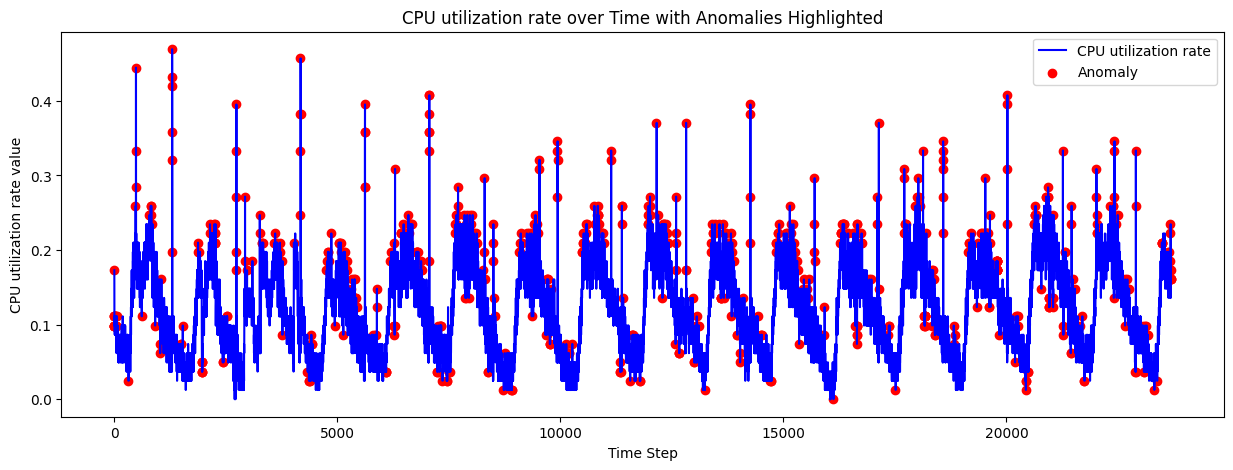

In [25]:
import numpy as np
import pandas as pd

def detect_outliers_moving_std(data, window_size, num_std):
    rolling_mean = np.convolve(data, np.ones(window_size) / window_size, mode='same')
    rolling_std = np.sqrt(np.convolve((data - rolling_mean)**2, np.ones(window_size) / window_size, mode='same'))
    differences = np.abs(data - rolling_mean)
    outliers = differences > num_std * rolling_std
    return outliers

data = df['CPU utilization rate']
window_size = 300
num_std = 2
outliers = detect_outliers_moving_std(data, window_size, num_std)

# 이상치 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(data, label='CPU utilization rate', color='blue')
plt.scatter(np.where(outliers)[0], data[outliers], color='red', label='Anomaly')
plt.title('CPU utilization rate over Time with Anomalies Highlighted')
plt.xlabel('Time Step')
plt.ylabel('CPU utilization rate value')
plt.legend()
plt.show()
mul = 1
df['Anomaly'] = outliers.astype(int) * mul

In [26]:
df['CPU utilization rate_lag1']  = df['CPU utilization rate'].shift(1)
df['CPU utilization rate_lag2']  = df['CPU utilization rate'].shift(2)
df['CPU utilization rate_lag3']  = df['CPU utilization rate'].shift(3)
df['CPU utilization rate_lag5']  = df['CPU utilization rate'].shift(5)
df = df.dropna()

In [27]:
'''!!!시간 수정!!!'''
past_history = 24
future_target = 6
STEP = 1
predict_col = 0

In [28]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# F_scaler와 T_scaler를 전역 변수로 정의
F_scaler = MinMaxScaler()
T_scaler = MinMaxScaler()

def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index, target_size):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

def preprocessing(data, past_history, future_target, STEP, predict_col, feature, augmentation_factor=1):

    TRAIN_SPLIT = int(len(data) * 0.8)

    features_considered = feature
    features = data[features_considered]
    F_dataset = features.values
    F_scaler.fit(F_dataset)
    F_dataset = F_scaler.transform(F_dataset)
    F_dataset = F_dataset.reshape(-1, len(features_considered))

    features_considered = ['CPU utilization rate']
    features = data[features_considered]
    T_dataset = features.values
    T_scaler.fit(T_dataset)
    T_dataset = T_scaler.transform(T_dataset)
    T_dataset = T_dataset.reshape(-1, 1)
    print(np.shape(T_dataset))

    anomal = ['Anomaly']
    features = data[anomal]
    anomal_dataset = features.values
    anomal_dataset = anomal_dataset.reshape(-1, 1)

    dataset = np.concatenate((T_dataset, F_dataset), axis=1)
    print(np.shape(dataset))

    x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, predict_col], 0, TRAIN_SPLIT, past_history, future_target, STEP)
    x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, predict_col], TRAIN_SPLIT, None, past_history, future_target, STEP)

    # 이상치 증강을 위해 이상치 데이터만 추출하여 증강 데이터셋 생성
    anomaly_indices = np.where(anomal_dataset[:, 0] == mul)[0]
    x_anomal_aug, y_anomal_aug = [], []
    for idx in anomaly_indices:
        if idx >= past_history and idx + future_target <= len(dataset):
            x_anomal_aug.append(dataset[idx-past_history:idx])
            y_anomal_aug.append(dataset[idx:idx + future_target, predict_col])

    # 증강 데이터 생성
    x_anomal_aug = np.array(x_anomal_aug)
    y_anomal_aug = np.array(y_anomal_aug)

    # 증강: 기존 이상치 데이터에 약간의 노이즈를 추가하여 새로운 데이터를 생성
    x_anomal_aug_noisy = []
    y_anomal_aug_noisy = []
    noise_factor = 0.05
    for _ in range(augmentation_factor):
        x_anomal_aug_noisy.append(x_anomal_aug + noise_factor * np.random.normal(size=x_anomal_aug.shape))
        y_anomal_aug_noisy.append(y_anomal_aug + noise_factor * np.random.normal(size=y_anomal_aug.shape))

    x_anomal_aug_noisy = np.concatenate(x_anomal_aug_noisy, axis=0)
    y_anomal_aug_noisy = np.concatenate(y_anomal_aug_noisy, axis=0)

    # 증강된 데이터 결합
    x_train_multi = np.concatenate((x_train_multi, x_anomal_aug, x_anomal_aug_noisy), axis=0)
    y_train_multi = np.concatenate((y_train_multi, y_anomal_aug, y_anomal_aug_noisy), axis=0)

    x_val_anomal, y_val_anomal = multivariate_data(anomal_dataset, anomal_dataset[:, predict_col], TRAIN_SPLIT, None, past_history, future_target, STEP)
    return x_train_multi, y_train_multi, x_val_multi, y_val_multi, x_val_anomal, y_val_anomal

# 예제 사용
data = df  # 사용자의 데이터프레임

feature_considered = ['CPU utilization rate_lag1', 'CPU utilization rate_lag2', 'CPU utilization rate_lag3', 'CPU utilization rate_lag5', 'Network inbound drops', 'Disk free space', 'Load 15 minutes', 'Anomaly']  # 사용자의 피처 목록
augmentation_factor = 10  # 증강 데이터 양을 조절하는 인자

x_train_multi, y_train_multi, x_val_multi, y_val_multi, x_val_anomal, y_val_anomal = preprocessing(data, past_history, future_target, STEP, predict_col, feature_considered, augmentation_factor)

print(f"x_train_multi shape: {x_train_multi.shape}")
print(f"y_train_multi shape: {y_train_multi.shape}")
print(f"x_val_multi shape: {x_val_multi.shape}")
print(f"y_val_multi shape: {y_val_multi.shape}")
print(f"x_val_anomal shape: {x_val_anomal.shape}")
print(f"y_val_anomal shape: {y_val_anomal.shape}")


(23677, 1)
(23677, 9)
x_train_multi shape: (10941, 24, 9)
y_train_multi shape: (10941, 6)
x_val_multi shape: (785, 24, 9)
y_val_multi shape: (785, 6)
x_val_anomal shape: (785, 24, 1)
y_val_anomal shape: (785, 6)


In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Flatten, Dense, concatenate, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Attention

# 어텐션 레이어 정의
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='u_context', shape=(input_shape[-1],), initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        u_it = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        att = tf.tensordot(u_it, self.u, axes=1)
        att_weights = tf.nn.softmax(att, axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(att_weights, -1), axis=1)
        return output, att_weights

# 모델 구성
input1 = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
conv1 = Conv1D(filters=16, kernel_size=1, activation='relu')(input1)
conv1_2 = Conv1D(filters=32, kernel_size=1, activation='relu')(conv1)
conv1_3 = Conv1D(filters=64, kernel_size=1, activation='relu')(conv1_2)
conv1_4 = Flatten()(conv1_3)
conv1_5 = LayerNormalization()(conv1_4)

input2 = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
lstm1 = LSTM(16, return_sequences=True)(input2)
lstm1_2 = LSTM(32, return_sequences=True)(lstm1)
lstm1_3 = LSTM(64, return_sequences=True)(lstm1_2)
attention_out, attention_weights = AttentionLayer()(lstm1_3)
lstm1_4 = LayerNormalization()(attention_out)

merge1 = concatenate([conv1_5, lstm1_4])

dense1 = Dense(64, activation='relu')(merge1)
dense2 = Dense(32, activation='relu')(dense1)

output = Dense(future_target)(dense2)  # Assuming future_target output features

model = Model(inputs=[input1, input2], outputs=output)
from tensorflow.keras.optimizers import Adam

# 옵티마이저 정의
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# 모델 요약 출력
model.summary()
model.fit([x_train_multi, x_train_multi], y_train_multi, epochs=20, batch_size=32, validation_data=([x_val_multi, x_val_multi], y_val_multi))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 24, 9)]              0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 24, 9)]              0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 24, 16)               160       ['input_3[0][0]']             
                                                                                                  
 lstm_3 (LSTM)               (None, 24, 16)               1664      ['input_4[0][0]']             
                                                                                            

In [31]:
answer_list = []
predict_list = []
anomal_list = []
for i in range(len(x_val_multi)):
    x = x_val_multi[i].reshape((-1, past_history, len(feature_considered)+1))
    answer = y_val_multi[i]
    anomal = y_val_anomal[i]
    predict = model.predict([x, x])[0]
    answer_list.append(answer)
    anomal_list.append(anomal)
    predict_list.append(predict)

1/1 [==============================] - 0s 21ms/step


In [32]:
answer = np.reshape(answer_list, (-1, 1))
predict = np.reshape(predict_list, (-1, 1))
anomal = np.reshape(anomal_list, (-1, 1))



In [33]:
np.shape(anomal_list)

(785, 6)

In [37]:
import numpy as np



# 값이 1인 인덱스 저장
indices_with_value_one = [index for index, value in enumerate(anomal) if np.any(value == mul)]

# 결과 출력
print("이상치 인덱스:", indices_with_value_one)


이상치 인덱스: [174, 189, 198, 234, 362, 399, 460, 489, 523, 550, 565, 580, 595, 610, 636, 637, 655, 669, 805, 808, 809, 812, 813, 814, 815, 816, 817, 818, 819, 820, 822, 823, 860, 1044, 1045, 1046, 1047, 1217, 1240, 1269, 1284, 1299, 1460, 1461, 1462, 1511, 1521, 1640, 1653, 1660, 1675, 1676, 1677, 1683, 1692, 1693, 1806, 1913, 1914, 1957, 1959, 1967, 1978, 1979, 1981, 1982, 1984, 1986, 1998, 2061, 2062, 2069, 2072, 2080, 2290, 2300, 2303, 2343, 2347, 2465, 2467, 2485, 2486, 2514, 2557, 2680, 2725, 2774, 2776, 3041, 3042, 3054, 3060, 3062, 3069, 3354, 3407, 3415, 3432, 3445, 3446, 3447, 3474, 3519, 3683, 3694, 3734, 3757, 3759, 3774, 3920, 3923, 3925, 3926, 4083, 4105, 4110, 4134, 4165, 4180, 4194, 4339, 4403, 4507, 4508, 4509, 4512, 4659, 4675, 4686, 4690, 4691, 4697, 4700, 4702, 4704, 4705, 4707, 4708]


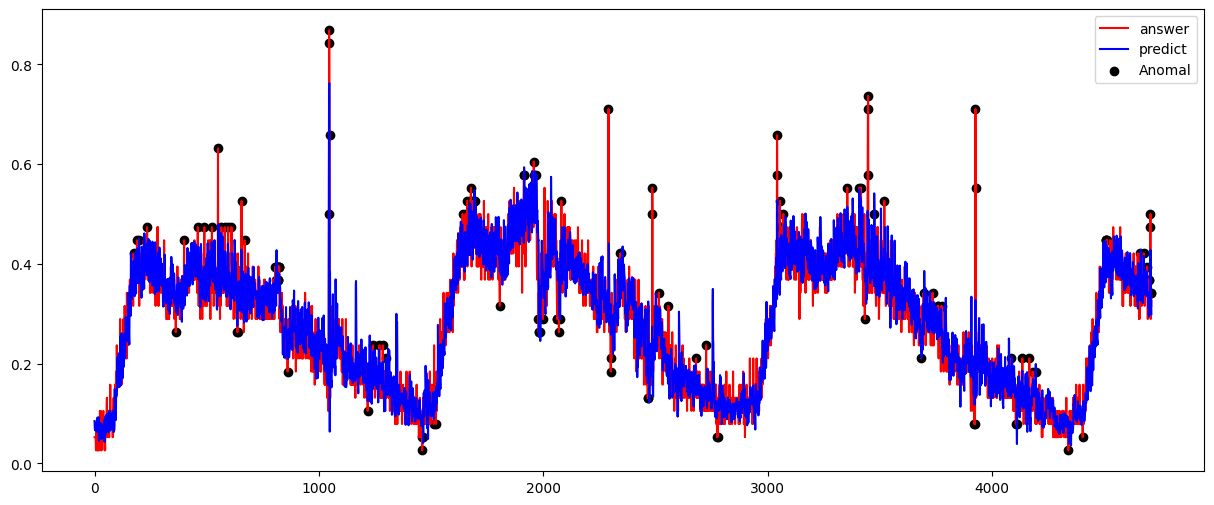

In [38]:
plt.figure(figsize=(15, 6))
plt.plot(answer, color = 'r', label = 'answer')
plt.plot(predict, color = 'b', label = 'predict')
plt.scatter(indices_with_value_one, [answer[i] for i in indices_with_value_one], color='k', label='Anomal', marker='o')  # 이상치 산점도

plt.legend()
plt.show()

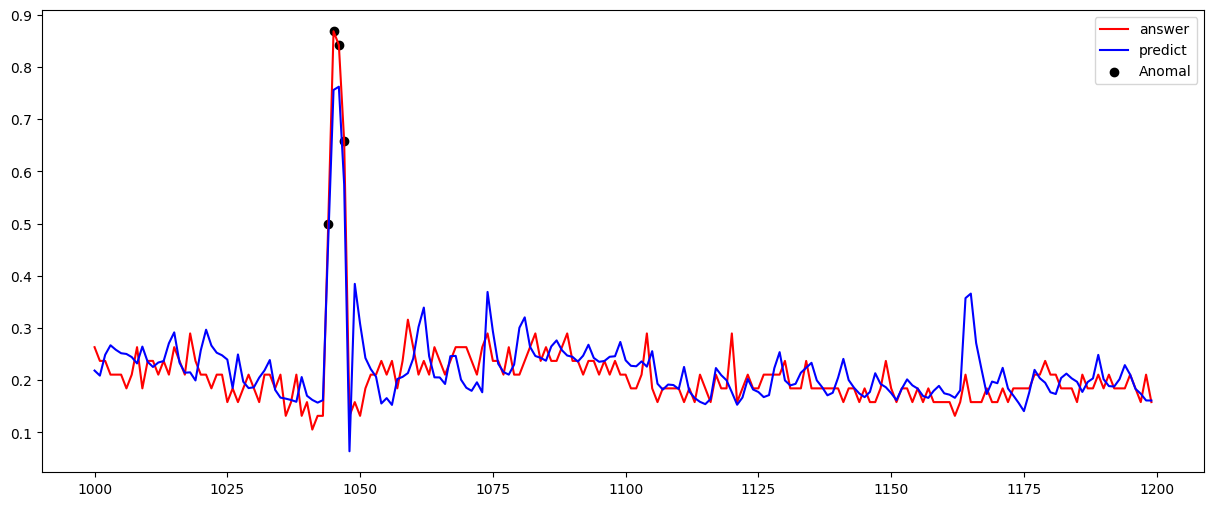

In [39]:

# Define the range you want to plot
start_idx = 1000
end_idx = 1200

# Slice the data arrays to the desired range
answer_slice = answer[start_idx:end_idx]
predict_slice = predict[start_idx:end_idx]

# Filter the indices with value one to the specified range
filtered_indices = [idx for idx in indices_with_value_one if start_idx <= idx < end_idx]
filtered_values = [answer[idx] for idx in filtered_indices]

plt.figure(figsize=(15, 6))
plt.plot(range(start_idx, end_idx), answer_slice, color='r', label='answer')
plt.plot(range(start_idx, end_idx), predict_slice, color='b', label='predict')
plt.scatter(filtered_indices, filtered_values, color='k', label='Anomal', marker='o')  # 이상치 산점도

plt.legend()
plt.show()

In [42]:
anomal_predict = [predict[i] for i, value in enumerate(anomal) if value == mul]
anomal_answer = [answer[i] for i, value in enumerate(anomal) if value == mul]

print(anomal_predict)
print(anomal_answer)

[array([0.40593362], dtype=float32), array([0.40121612], dtype=float32), array([0.45007384], dtype=float32), array([0.4414805], dtype=float32), array([0.31491038], dtype=float32), array([0.3388029], dtype=float32), array([0.37543878], dtype=float32), array([0.38445994], dtype=float32), array([0.41802928], dtype=float32), array([0.34265712], dtype=float32), array([0.43022853], dtype=float32), array([0.39543948], dtype=float32), array([0.4249803], dtype=float32), array([0.3500634], dtype=float32), array([0.27569932], dtype=float32), array([0.3360401], dtype=float32), array([0.41899446], dtype=float32), array([0.34632638], dtype=float32), array([0.36979112], dtype=float32), array([0.33609554], dtype=float32), array([0.31637144], dtype=float32), array([0.36881927], dtype=float32), array([0.35015428], dtype=float32), array([0.35651472], dtype=float32), array([0.35591397], dtype=float32), array([0.34133506], dtype=float32), array([0.37714514], dtype=float32), array([0.38266066], dtype=float3

In [43]:
#정상
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 각 요소별로 차이 계산
diffs = [abs(pred - ans) for pred, ans in zip(predict, answer)]

# 평균 계산
mean_diff = np.mean(diffs)

# 평균을 answer의 각 요소에 대한 평균 값으로 나누고 100을 곱하여 백분율로 표현
mean_percentage_diff = (mean_diff / np.mean(answer)) * 100
a = answer
b = predict
from sklearn.metrics import mean_absolute_percentage_error
#print(mae(a, b).numpy())
print("전체 구간 mse :", mean_squared_error(a, b))
#print(r2_score(a, b))
#print(RMSE(a, b))
#print(mean_absolute_percentage_error(answer, predict))
print("전체 구간 평균 백분율:", mean_percentage_diff)


#이상
import numpy as np


# 각 요소별로 차이 계산
diffs = [abs(pred - ans) for pred, ans in zip(anomal_predict, anomal_answer)]

# 평균 계산
mean_diff = np.mean(diffs)

# 평균을 answer의 각 요소에 대한 평균 값으로 나누고 100을 곱하여 백분율로 표현
mean_percentage_diff = (mean_diff / np.mean(answer)) * 100
a = anomal_answer
b = anomal_predict
from sklearn.metrics import mean_absolute_percentage_error
#print(mae(a, b).numpy())
print("이상 구간 mse :", mean_squared_error(a, b))
#print(r2_score(a, b))
#print(mean_absolute_percentage_error(answer, predict))
print("이상 구간 평균 백분율:", mean_percentage_diff)


전체 구간 mse : 0.0019976749158452825
전체 구간 평균 백분율: 11.916541571887459
이상 구간 mse : 0.011853088782911046
이상 구간 평균 백분율: 27.194959890940833


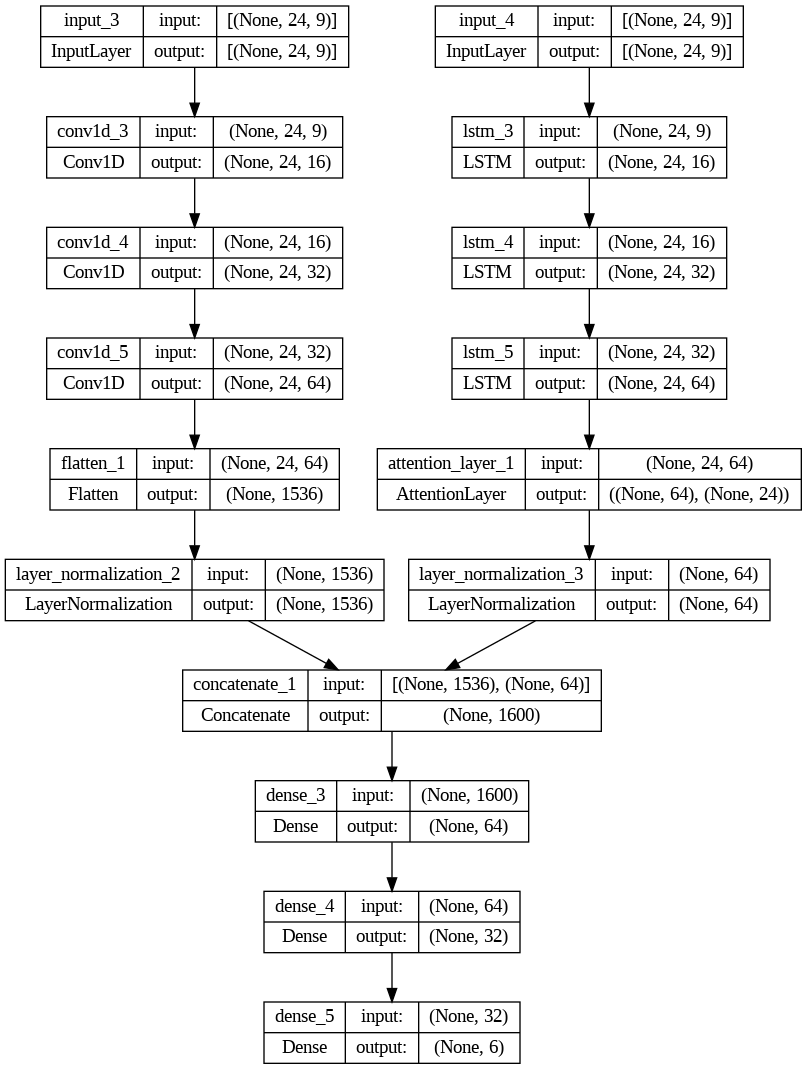

In [44]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the model plot in Colab
from IPython.display import Image
Image(filename='model_plot.png')